In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import dask.array as da

In [ ]:
# !pip install keras-video-generators
from __future__ import absolute_import
from __future__  import division
from __future__ import print_function
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
import cv2
import matplotlib.pyplot as plt

In [ ]:
import os
import glob

from tensorflow.keras.utils import Sequence

In [ ]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
# from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/DeepLearning_Test/VIDEO_RGB_NEW

backhand  bvolley  forehand  fvolley  service  smash


In [ ]:
import random

train_size = 0.8  # training set proportion
val_size = 0.1  # validation set proportion

# set how many videos to incorporate in dataset from each class
max_class_size = 300 # something arbitrarily large will generate .npy for all data

random.seed(1)  # generate same random dataset

In [ ]:
# --- CREATING DATASET CSV FILE --- #
import csv

with open('/content/drive/MyDrive/DeepLearning_Test/data/data_file.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    
    # get subdirectories in VIDEO_RGB

    path = os.path.join('/content/drive/MyDrive/DeepLearning_Test/VIDEO_RGB_NEW/')

    # ignore .DS_store
    class_folders = [item for item in os.listdir(path) if not item.startswith('.')]
    
    
    # iterate over each folder, and write train/test samples to csv file
    for class_label in class_folders:
#         print class_label

        subpath = os.path.join(path, class_label)

        videos = []
        for vid in os.listdir(subpath):
            
            # make sure vid is a file and not .DS_Store
            if os.path.isfile(os.path.join(subpath, vid)) and not vid.startswith('.'):
                vid = os.path.splitext(vid)[0]
                videos.append(vid)

        
        # TURN ON RANDOM SHUFFLE WHEN GENERATING ACTUAL DATASET
        random.shuffle(videos)  # NOTE: shuffles videos in place

        # alter size of dataset
        if max_class_size < len(videos):
            videos = videos[:max_class_size]
            
        # ------------------------------------------------------------ #

        # split into training and test sets
        train_split_ind = int(round(train_size*len(videos)))
        val_split_ind = train_split_ind + int(round(val_size*len(videos)))
        
        train = videos[0:train_split_ind]
        validation = videos[train_split_ind:val_split_ind]
        test = videos[val_split_ind:]

        # --- RELABEL TO CONSOLIDATE CLASSES --- #
        if class_label == 'backhand2hands' or class_label == 'backhand_slice':
            class_label = 'backhand'
            
        if class_label == 'forehand_flat' or class_label == 'forehand_openstands' or class_label == 'forehand_slice':
            class_label = 'forehand'
        
        if class_label == 'forehand_volley':
            class_label = 'fvolley'

        if class_label == 'backhand_volley':
            class_label = 'bvolley'            
            
        if class_label == 'flat_service' or class_label == 'kick_service' or class_label == 'slice_service':
            class_label = 'service'

        # write train_size proportion to csv as train
        for sample in train:
            writer.writerow(['train'] + [class_label] + [sample])
            
        # write val_size proportion to csv as validation
        for sample in validation:
            writer.writerow(['validation'] + [class_label] + [sample])
        
        # write remaining proportion to csv as test
        for sample in test:
            writer.writerow(['test'] + [class_label] + [sample])

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/DeepLearning_Test/data/data_file.csv')
test.head()
# test[test[p14_fvolley_s2=='p55_fslice_s3']]
# test[test.p14_fvolley_s2=='p55_fslice_s3']

,train,backhand,p27_bslice_s1
0,train,backhand,p49_bslice_s1
1,train,backhand,p48_backhand2h_s2
2,train,backhand,p2_backhand2h_s3
3,train,backhand,p46_backhand_s1
4,train,backhand,p47_bslice_s2


In [ ]:
pd.read_csv('/content/drive/MyDrive/DeepLearning_Test/data/data_file.csv').shape

(1394, 3)

Extracting and Saving Sequences

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from data_utils import DataSet

import numpy as np
import os.path
import time

In [ ]:
def load_cnn_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(480, 640, 3), pooling='avg')
    
    print(base_model.summary())
    outputs = base_model.get_layer('global_average_pooling2d').output # 'avg_pool'

    cnn_model = Model(inputs=base_model.input, outputs=outputs)

    return cnn_model

In [ ]:
cnn_model = load_cnn_model()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 239, 319, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 239, 319, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# ---- RUN THE FOLLOWING CELLS TO GENERATE .NPY SEQ FOR ALL VIDEOS IN DATASET ----- # 
#      SEQUENCES THAT ALREADY EXIST WILL BE SKIPPED

seq_length = 16
dataset = DataSet(cnn_model)

In [ ]:
tic = time.time()

for ind, sample in enumerate(dataset.data):
  
  path = os.path.join('/content/drive/MyDrive/DeepLearning_Test/data/', 'sequences', sample[1], sample[2] + '-' + str(seq_length) + '-features.npy')
  
  if os.path.isfile(path):
    print("Sequence: {} already exists".format(ind))
  else:
    print("Generating and saving sequence: {}".format(ind))
    sequence = dataset.extract_seq_features(sample)

print("Time Elapsed: {}".format(time.time() - tic))

Sequence: 0 already exists
Sequence: 1 already exists
Sequence: 2 already exists
Sequence: 3 already exists
Sequence: 4 already exists
Sequence: 5 already exists
Sequence: 6 already exists
Sequence: 7 already exists
Sequence: 8 already exists
Sequence: 9 already exists
Sequence: 10 already exists
Sequence: 11 already exists
Sequence: 12 already exists
Sequence: 13 already exists
Sequence: 14 already exists
Sequence: 15 already exists
Sequence: 16 already exists
Sequence: 17 already exists
Sequence: 18 already exists
Sequence: 19 already exists
Sequence: 20 already exists
Sequence: 21 already exists
Sequence: 22 already exists
Sequence: 23 already exists
Sequence: 24 already exists
Sequence: 25 already exists
Sequence: 26 already exists
Sequence: 27 already exists
Sequence: 28 already exists
Sequence: 29 already exists
Sequence: 30 already exists
Sequence: 31 already exists
Sequence: 32 already exists
Sequence: 33 already exists
Sequence: 34 already exists
Sequence: 35 already exists
Se

In [ ]:
"""
Train the LRCNN model. Parameters are set in params.json file in the
relevant directory under "/experiments".
"""

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Lambda, Dropout, GRU
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from data_utils import DataSet

import numpy as np
import os
import os.path
import time

from utils import Params
from utils import set_logger
import argparse
import logging

# import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
!ls drive/MyDrive/DeepLearning_Test/experiments

base_model


In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--model_dir', default='drive/MyDrive/DeepLearning_Test/experiments/base_model',
										help="Directory containing params.json")

_StoreAction(option_strings=['--model_dir'], dest='model_dir', nargs=None, const=None, default='drive/MyDrive/DeepLearning_Test/experiments/base_model', type=None, choices=None, help='Directory containing params.json', metavar=None)

In [ ]:
# --- RNN MODEL --- #
def lstm(num_features=2048, hidden_units=256, dense_units=256, reg=1e-1, dropout_rate=1e-1, seq_length=16, num_classes=6):
		
	# hidden_units: dimension of cell
	# dense_units: number of neurons in fully connected layer above LSTM
	# reg: regularization for LSTM and dense layer
	# - currently adding L2 regularization for RNN connections, and for inputs to dense layer
	
	model = Sequential()
	
	# return_sequences flag sets whether hidden state returned for each time step
	# NOTE: set return_sequences=True if using TimeDistributed, else False


	# LSTM layer (dropout)
	model.add(Dropout(dropout_rate, input_shape=(seq_length, num_features)))  # input to LSTM
	model.add(LSTM(hidden_units, return_sequences=True))
	
	# --- AVERAGE LSTM OUTPUTS --- #
	
	# dropout between LSTM and softmax
	model.add(TimeDistributed(Dropout(dropout_rate)))

	# commenting out additional FC layer for now
	# model.add(TimeDistributed(Dense(dense_units)))
	
	# apply softmax
	model.add(TimeDistributed(Dense(num_classes, activation="softmax")))
	
	# average outputs
	average_layer = Lambda(function=lambda x: K.mean(x, axis=1))
	model.add(average_layer)
	
	# --- ONLY TAKE LAST LSTM OUTPUT --- #
	# model.add(Dense(dense_units))
	# model.add(Dense(num_classes, activation="softmax"))
	
	return model

In [ ]:
# --- TRAINING FUNCTION --- #
def train(model_dir, cnn_model, saved_model=None, 
			learning_rate = 1e-5, decay=1e-6, 
			train_size = 0.8, seq_length=16,
			hidden_units=256, dense_units=256, reg=1e-1, dropout_rate=1e-1,
			num_classes=6, batch_size=16, nb_epoch=100, 
			image_shape=None):


	# ---- CALL BACK FUNCTIONS FOR FIT_GENERATOR() ---- #
  checkpoints_dir = os.path.join(model_dir, 'checkpoints')
  if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)

  checkpointer = ModelCheckpoint(
      filepath=os.path.join(checkpoints_dir, 'lstm_weights.{epoch:004d}-{val_loss:.3f}.hdf5'),
      verbose=1, save_best_only=False, period=50)

  # tensorboard info
  tb = TensorBoard(log_dir=model_dir)

  # ------------------------------------------------- # 


  # PREPARE DATASET
  dataset = DataSet(cnn_model, seq_length)

  # steps_per_epoch = number of batches in one epoch
  steps_per_epoch = (len(dataset.data) * train_size) // batch_size

  # create train and validation generators
  generator = dataset.frame_generator(batch_size, 'train')
  (X_train, y_train) = dataset.generate_data("train")
  X_train = tf.ragged.constant(X_train, ragged_rank=1)

  # val_generator = dataset.frame_generator(batch_size, 'validation') # use all validation data each time?
  (X_val, y_val) = dataset.generate_data('validation')

  # load or create model
  if saved_model:
    rnn_model = load_model(saved_model)
  else:
    rnn_model = lstm(hidden_units=hidden_units, dense_units=dense_units, 
            reg=reg, dropout_rate=dropout_rate,
            seq_length=seq_length, num_classes=num_classes)

  # setup optimizer: ADAM algorithm
  optimizer = Adam(lr=learning_rate, decay=decay)

  # metrics for judging performance of model
  metrics = ['categorical_accuracy'] # ['accuracy']  # if using 'top_k_categorical_accuracy', must specify k

  rnn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer,
      metrics=metrics)

  print(rnn_model.summary())

  # use fit generator to generate data on the fly
  history = rnn_model.fit(X_train, y_train,
                  steps_per_epoch=steps_per_epoch,
                  epochs=nb_epoch,
                  verbose=1,
                  callbacks=[tb, checkpointer],
                  validation_data=(X_val, y_val),
                  validation_steps=1)  # using all validation data for better metrics

  return history

In [ ]:
!ls drive/MyDrive/DeepLearning_Test/data

data_file.csv  sequences


In [ ]:
args = parser.parse_args(args=[])
tf.random.set_seed(42)
json_path = os.path.join(args.model_dir, 'params.json')
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)

# ----- DUMMY MODEL TO PASS IN AS CNN_MODEL ---- #
#       (feature extraction not performed in this script)

a = Input(shape=(1,))
b = Dense(1)(a)
model = Model(inputs=a, outputs=b)

cnn_model = Model(inputs=a, outputs=b)


# ---- LOAD PARAMETERS FOR TRAINING ---- #

if params.saved_model == "None":
  saved_model = None
else:
  saved_model = params.saved_model

# --- hyperparameters --- #
learning_rate = params.learning_rate
decay = params.decay

hidden_units = params.hidden_units
dense_units = params.dense_units

reg = params.reg
dropout_rate = params.dropout_rate

batch_size = params.batch_size
nb_epoch = params.nb_epoch

# --- other parameters --- #
train_size = params.train_size
num_classes = params.num_classes
seq_length = params.seq_length

# --- EXECUTE TRAINING --- #

history = train(args.model_dir, cnn_model, saved_model=saved_model, 
          learning_rate = learning_rate, decay = decay, 
          train_size = train_size, seq_length = seq_length,
          hidden_units = hidden_units, dense_units = dense_units, reg=reg,
          num_classes = num_classes,
          batch_size = batch_size, nb_epoch = nb_epoch)

print("\nCompleted training! \n")

# --- SAVE HISTORY AS PICKLE FILE --- #
save_path = os.path.join(args.model_dir, 'train_history.pkl')

/content/data_utils.py:332: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X), np.array(y)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_20 (Dropout)        (None, 16, 2048)          0         
                                                                 
 lstm_10 (LSTM)              (None, 16, 128)           1114624   
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 128)          0         
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 16, 6)            774       
 stributed)                                                      
                                                                 
 lambda_10 (Lambda)          (None, 6)                 0         
                                                                 
Total params: 1,115,398
Trainable params: 1,115,398
N

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
Epoch 1/300
8/8 [==============================] - 3s 98ms/step - loss: nan - categorical_accuracy: 0.1953 - val_loss: 1.7521 - val_categorical_accuracy: 0.2174
Epoch 2/300
8/8 [==============================] - 0s 39ms/step - loss: nan - categorical_accuracy: 0.2186 - val_loss: 1.7479 - val_categorical_accuracy: 0.2319
Epoch 3/300
8/8 [==============================] - 0s 40ms/step - loss: nan - categorical_accuracy: 0.2285 - val_loss: 1.7369 - val_categorical_accuracy: 0.2609
Epoch 4/300
8/8 [==============================] - 0s 39ms/step - loss: nan - categorical_accuracy: 0.2751 - val_loss: 1.7332 - val_categorical_accuracy: 0.2681
Epoch 5/300
8/8 [==============================] - 0s 38ms/step - loss: nan - categorical_accuracy: 0.2841 - val_loss: 1.7298 - val_categorical_accuracy: 0.3116
Epoch 6/300
8/8 [==============================] - 0s 39ms/step - loss: nan - categorical_accuracy: 0.2823 - val_loss: 1.7245 - val_categorical_accuracy: 0.2754
Epoch 7/300
8/8 [============

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
with open(save_path, 'wb') as save_file:
  pickle.dump(history.history, save_file, protocol=2) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/content/data_utils.py:332: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X), np.array(y)


35/35 [==============================] - 1s 9ms/step - loss: nan - categorical_accuracy: 0.9686
Train Loss: nan
Train Accuracy: 0.969

5/5 [==============================] - 0s 6ms/step - loss: 0.7426 - categorical_accuracy: 0.7899
Val Loss: 0.743
Val Accuracy: 0.790

5/5 [==============================] - 0s 6ms/step - loss: 0.7751 - categorical_accuracy: 0.7589
Test Loss: 0.775
Test Accuracy: 0.759

              precision    recall  f1-score   support

    backhand       0.82      0.90      0.86        30
     bvolley       0.73      0.65      0.69        17
    forehand       0.87      0.87      0.87        30
     fvolley       1.00      0.65      0.79        17
     service       0.64      0.97      0.77        30
       smash       0.43      0.18      0.25        17

    accuracy                           0.76       141
   macro avg       0.75      0.70      0.70       141
weighted avg       0.76      0.76      0.74       141



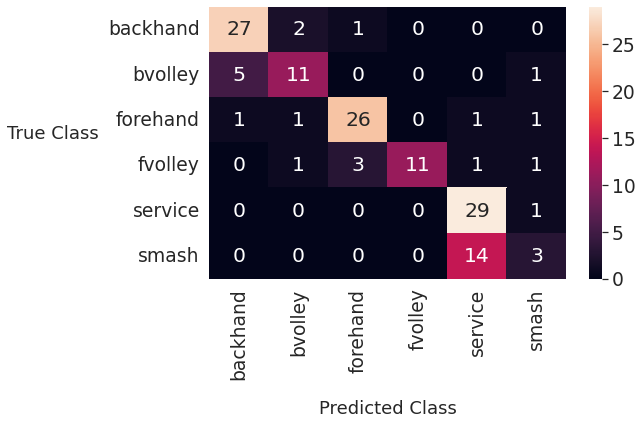

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ------ REPLICATE PARAMETERS USED IN EXPERIMENT ------ #

# ---- HYPER-PARAMETERS TO BE SET ---- #

learning_rate= 1e-3 # 1e-4
decay=0.0

hidden_units = 128
dense_units = 128
reg = 0.0           # L2 regularization
dropout_rate = 0.3  # dropout regularization
batch_size = 128
nb_epoch = 300 # 100


# ---- OTHER PARAMETERS ---- #
train_size = 0.8  # proportion of dataset that is training
saved_model = None  # None, or pass in weights file
# saved_model = "data/checkpoints/lstm_weights.0026-0.239.hdf5"

num_classes = 6
seq_length = 16    # essentially number of frames


# --- LOAD DUMMY CNN MODEL --- #
a = Input(shape=(1,))
b = Dense(1)(a)
model = Model(inputs=a, outputs=b)

cnn_model = Model(inputs=a, outputs=b)


# ------ EVALUATE MODEL ------ #
# have to reinstantiate model to load weights properly (python3 --> python2.7 problem)
rnn_model = lstm(hidden_units=hidden_units, dense_units=dense_units, 
                reg=reg, dropout_rate=dropout_rate,
                seq_length=seq_length, num_classes=num_classes)

# setup optimizer: ADAM algorithm
optimizer = Adam(lr=learning_rate, decay=decay)

# metrics for judging performance of model
metrics = ['categorical_accuracy'] # ['accuracy']  # if using 'top_k_categorical_accuracy', must specify k

rnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer,
    metrics=metrics)


# load saved weights
folder_path = 'drive/MyDrive/DeepLearning_Test/experiments/base_model/checkpoints/'

saved_weights = os.path.join(folder_path, 'lstm_weights.0300-0.743.hdf5')
rnn_model.load_weights(saved_weights)

# load and prepare test set
dataset = DataSet(cnn_model)

X_train, Y_train = dataset.generate_data('train')
X_train = tf.ragged.constant(X_train, ragged_rank=1)
X_val, Y_val = dataset.generate_data('validation')
X_test, Y_test = dataset.generate_data('test')

score = rnn_model.evaluate(x=X_train, y=Y_train, verbose=1)
print("Train Loss: %2.3f" % score[0])
print("Train Accuracy: %1.3f\n" % score[1])

score = rnn_model.evaluate(x=X_val, y=Y_val, verbose=1)
print("Val Loss: %2.3f" % score[0])
print("Val Accuracy: %1.3f\n" % score[1])

score = rnn_model.evaluate(x=X_test, y=Y_test, verbose=1)
print("Test Loss: %2.3f" % score[0])
print("Test Accuracy: %1.3f\n" % score[1])


# --- MISCLASSIFICATION ANALYSIS --- #
Y_pred = rnn_model.predict(X_test)
Y_pred_class = np.argmax(Y_pred,axis=1)
Y_test_class = np.argmax(Y_test, axis=1)


target_names = ['backhand', 'bvolley', 'forehand', 'fvolley', 
                'service', 'smash']
print(classification_report(Y_test_class, Y_pred_class, target_names=target_names))
conf_matrix = confusion_matrix(Y_test_class, Y_pred_class)

sns.set(font_scale=1.7)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (8,5))
ax = sns.heatmap(df_cm, annot=True)
ax.set_xlabel('Predicted Class', fontsize=18, labelpad=20)
ax.set_ylabel('True Class', fontsize=18, rotation=0, labelpad=55)
plt.show()